# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [106]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [30]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';',escapechar='\\',error_bad_lines = False)

In [31]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
rows,columns=azdias.shape
print("Number of rows in the AZDIAS dataset :{}".format(rows))
print("Number of columns in the AZDIAS dataset :{}".format(columns))

Number of rows in the AZDIAS dataset :891221
Number of columns in the AZDIAS dataset :85


In [32]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [33]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [34]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [35]:
# Create list of the missing and unknown values for all the features.
missing_or_unknown=list()
for values in feat_info.missing_or_unknown:
    missing_or_unknown.append(values[1:-1].split(","))

print(missing_or_unknown)

[['-1', '0'], ['-1', '0', '9'], ['-1', '0'], ['0'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['0'], [''], [''], ['-1', '0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['-1', '0'], ['-1', '0'], ['0'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1'], ['-1'], ['-1', '0'], ['-1'], ['-1', '9'], ['0'], [''], [''], ['-1', '0'], ['-1'], ['-1', '0'], ['-1', '0'], ['0'], [''], ['-1', '0'], [''], ['0'], ['-1'], ['-1'], ['-1', 'X'], ['XX'], ['-1', 'XX'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1', '0'], ['-1', '0'], ['-1'], ['-1'], ['-1'], [''], ['-1', '0'], [''], [''], ['-1', '0'], [''], ['-1'], ['-1'], ['-1'], ['-1'], ['-1', '0'], ['-1'], ['-1'], ['-1', '9'], ['-1', '0'], ['-1', '9']]


In [36]:
# Identify missing or unknown data values and convert them to NaNs.
for feature,missing_values in zip(feat_info.attribute,missing_or_unknown):
    if missing_values[0] != "": 
        for missing_value in missing_values:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            azdias.loc[azdias[feature] == missing_value, feature] = np.nan

In [37]:
# Verify if all the missing and unknowns are converted into NaN
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [38]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null = azdias.isnull().sum()
null

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [39]:
# Investigate patterns in the amount of missing data in each column.
per_null = null / azdias.shape[0] * 100
per_null.sort_values(ascending = False, inplace=True)
per_null

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

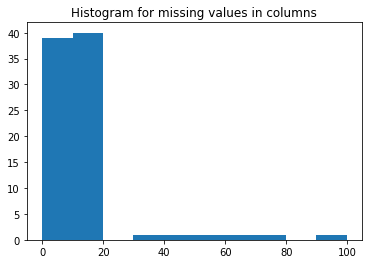

In [40]:
plt.hist(per_null)
plt.title('Histogram for missing values in columns')
plt.show()

In [41]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
feat_drop = per_null[per_null>30].index
print('The following features would be removed:')
for i in feat_drop:
    print(i)   

The following features would be removed:
TITEL_KZ
AGER_TYP
KK_KUNDENTYP
KBA05_BAUMAX
GEBURTSJAHR
ALTER_HH


In [42]:
azdias.drop(columns=feat_drop,axis="columns",inplace=True)
azdias.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [43]:
rows,columns=azdias.shape
print("Number of rows in the AZDIAS dataset after removing outliers:{}".format(rows))
print("Number of columns in the AZDIAS dataset after removing outliers :{}".format(columns))

Number of rows in the AZDIAS dataset after removing outliers:891221
Number of columns in the AZDIAS dataset after removing outliers :79


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram, let us remove the features which have missing values more than 30 percent. The following columns are removed: TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH.

There are some features which have same percentage of missing data values. This suggests that such group might contain similar information. For eg:
1. KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3 : 14.959701 percent missing values.
2. PLZ8_GBZ, PLZ8_HHZ, PLZ8_BAUMAX, PLZ8_ANTG4, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG2 : 13.073637 percent missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [44]:
# How much data is missing in each row of the dataset?
null_rows=azdias.isnull().sum(axis=1)
null_rows

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

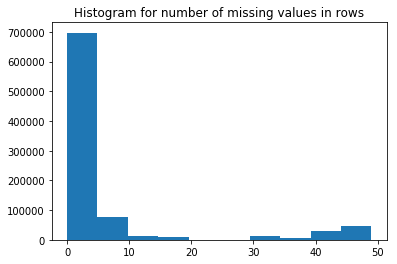

In [45]:
plt.hist(null_rows)
plt.title('Histogram for number of missing values in rows')
plt.show()

In [46]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# A clear division of the dataset can be observed. So we will divide the dataset into subsets with > 30 and <30 missing values.
null_rows_less_30=azdias[null_rows<30]
null_rows_more_30=azdias[null_rows>=30]

In [47]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
colums_less_missing_values = null[null<18].index
colums_less_missing_values=colums_less_missing_values[:5]
colums_less_missing_values

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER'],
      dtype='object')

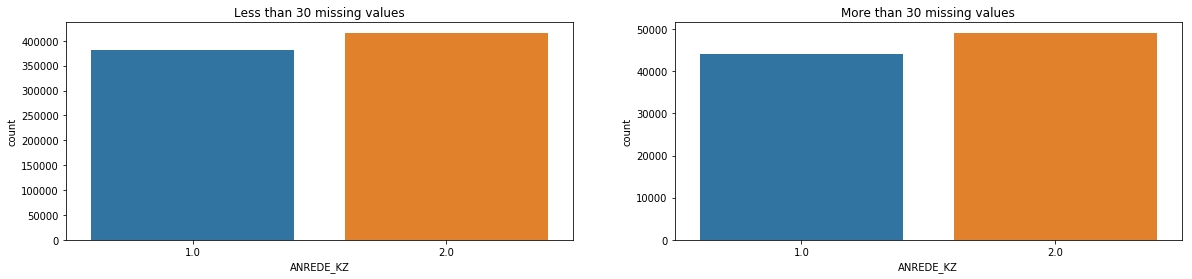

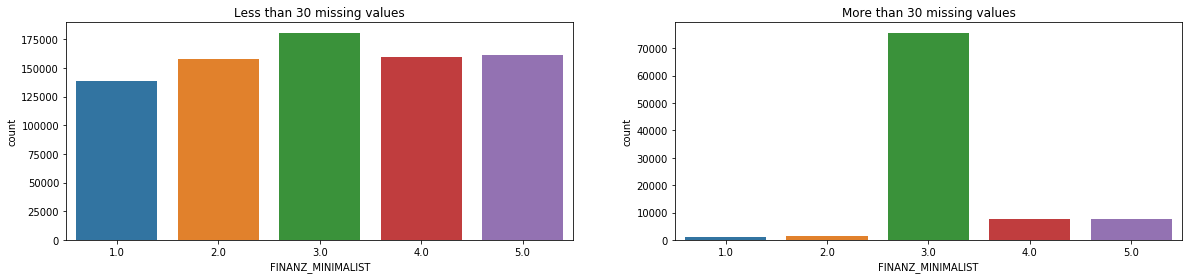

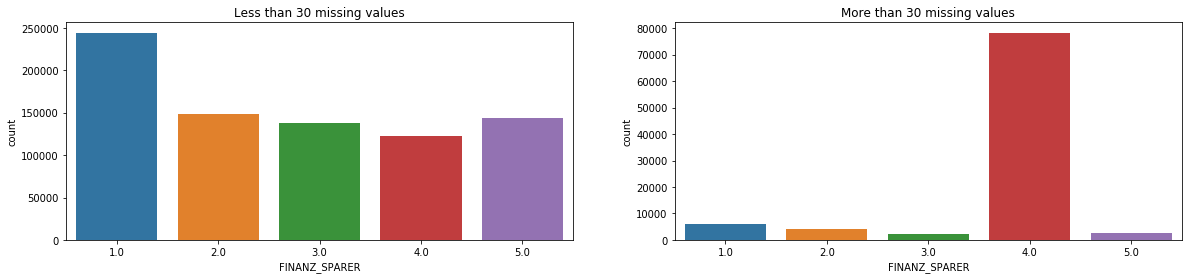

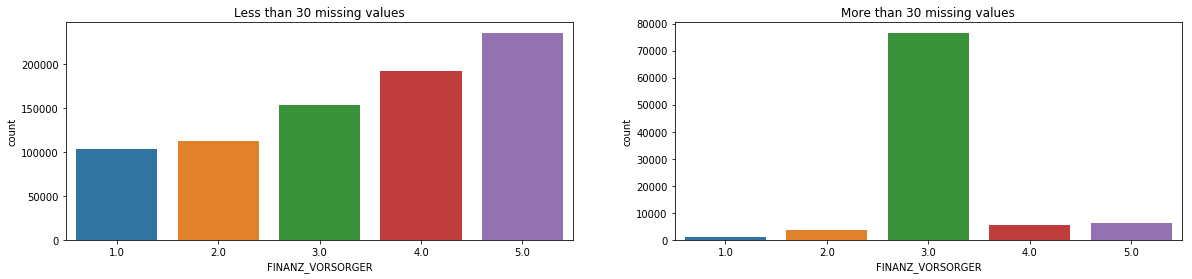

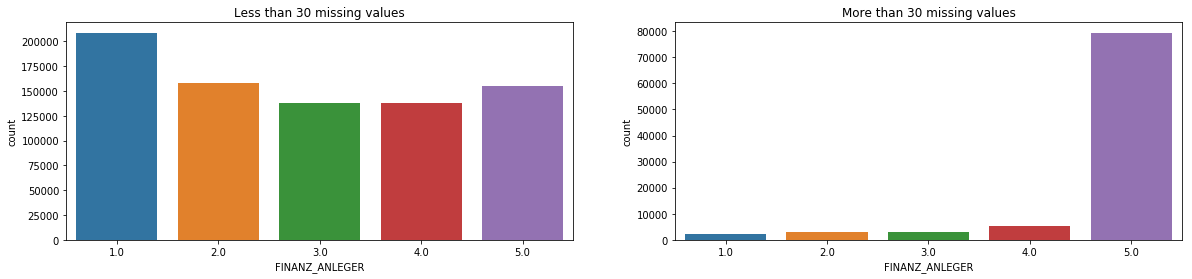

In [48]:
def dist_plot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)
    ax1.set_title('Less than 30 missing values')
    sns.countplot(azdias.loc[null_rows_less_30.index,column],ax=ax1)

    ax2.set_title('More than 30 missing values')
    sns.countplot(azdias.loc[null_rows_more_30.index,column],ax=ax2)
    
    plt.show()
    

for i in range(colums_less_missing_values.size):
    dist_plot(colums_less_missing_values[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

From the above distribution plots, the data with lot of missing values (greater than 30) seems to be qualitatively degraded. It does not show a similar distribution as that for the data with less missing values. This might cause a problem while clustering. It is recommended to either remove this subset of data or else replace the missing values with some statistical value like mean or median. I would choose to remove this subset of data. Henceforth, only dataset with missing values in rows less than 30 would be used.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [49]:
# How many features are there of each data type?
feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ_feat=feat_info[feat_info.type=="categorical"]
categ_feat

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [51]:
# Seperate binary and multi level categeorical variables
missing_less_30_datasubset=azdias[null_rows<30]
binary_categories=[]
multi_categeories = []
for feat in categ_feat.attribute:
    try:
        if missing_less_30_datasubset[feat].nunique()==2:
            binary_categories.append(feat)
        else:
            multi_categeories.append(feat)
    except:
        print('{} Column dropped'.format(feat))

AGER_TYP Column dropped
TITEL_KZ Column dropped
KK_KUNDENTYP Column dropped


In [52]:
for feat in binary_categories:
    print(missing_less_30_datasubset[feat].value_counts())

2.0    416177
1.0    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [53]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Non numeric binary categeories
missing_less_30_datasubset["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)

# Multi class categeories
missing_less_30_datasubset=pd.get_dummies(data=missing_less_30_datasubset,columns=multi_categeories)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [54]:
missing_less_30_datasubset.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,1,0,0,0,0,0,0


In [55]:
rows,columns=missing_less_30_datasubset.shape
print("Number of rows in the re-encoded dataset :{}".format(rows))
print("Number of columns in the re-encoded dataset :{}".format(columns))

Number of rows in the re-encoded dataset :798061
Number of columns in the re-encoded dataset :194


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In the dataset, the following encoding were performed:
1. For numerical binary categeorical features ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ and VERS_TYP, no change was implemented.
2. For non-numeric binary categeorical variable OST_WEST_KZ, the values were replaced with 0 and 1.
3. For other multi level categeorical features, one hot encoding was implemented using get_dummies function.
4. The dataset has total 194 features/columns after the re-encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [56]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
missing_less_30_datasubset.PRAEGENDE_JUGENDJAHRE.head(5)

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [57]:
# Create mapping dictionaries for decade
decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

# Create mapping dictionaries for movement
movement={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

missing_less_30_datasubset["DECADE"]=missing_less_30_datasubset.PRAEGENDE_JUGENDJAHRE
missing_less_30_datasubset["DECADE"].replace(decade,inplace=True)

missing_less_30_datasubset["MOVEMENT"]=missing_less_30_datasubset.PRAEGENDE_JUGENDJAHRE
missing_less_30_datasubset["MOVEMENT"].replace(movement,inplace=True)

missing_less_30_datasubset.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

In [58]:
missing_less_30_datasubset.DECADE.head(5)

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: DECADE, dtype: float64

In [59]:
missing_less_30_datasubset.MOVEMENT.head(5)

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: MOVEMENT, dtype: float64

In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
missing_less_30_datasubset.CAMEO_INTL_2015.head(5)

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [61]:
# Create mapping dictionariy for wealth
wealth={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }

# Create mapping dictionariy for life stage
life_stage={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

missing_less_30_datasubset["WEALTH"]=missing_less_30_datasubset.CAMEO_INTL_2015
missing_less_30_datasubset["WEALTH"].replace(wealth,inplace=True)

missing_less_30_datasubset["LIFE_STAGE"]=missing_less_30_datasubset.CAMEO_INTL_2015
missing_less_30_datasubset["LIFE_STAGE"].replace(life_stage,inplace=True)

missing_less_30_datasubset.drop("CAMEO_INTL_2015",axis=1,inplace=True)

In [62]:
missing_less_30_datasubset.WEALTH.head(5)

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: WEALTH, dtype: float64

In [63]:
missing_less_30_datasubset.LIFE_STAGE.head(5)

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: LIFE_STAGE, dtype: float64

In [64]:
rows,columns=missing_less_30_datasubset.shape
print("Number of rows in the dataset after engineering mixed type features :{}".format(rows))
print("Number of columnsin the dataset after engineering mixed type features :{}".format(columns))

Number of rows in the dataset after engineering mixed type features :798061
Number of columnsin the dataset after engineering mixed type features :196


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The two features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were decoded in the following way:
- Create mapping dictionaries:
    - Decade: 1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, 6: 90s
    - Movement = 0: mainstream, 1: Avantgarde
    - Wealth = 1: wealthy house, 2: prosperous house, 3: Comfortable Households, 4: Less Affluent Households, 5: Poorer Households
    - Life stage = 1: Pre-Family Couples & Singles, 2: Young Couples With Children, 3: Families With School Age Children, 4: Elders In Retirement, 5: Older Families & Mature Couples
- Create the corresponding columns in the dataset.
- Replace the original values with the mapped ones.
- Remove the original variables.
- The other mixed type features are dropped in the next section.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# Drop other mixed type features
mixed_variables=feat_info[feat_info.type=="mixed"]
for feature in mixed_variables["attribute"]:
    if feature in missing_less_30_datasubset.columns:
        missing_less_30_datasubset.drop(feature,axis=1,inplace=True)
        print('Feature {} is removed'.format(feature))

Feature LP_LEBENSPHASE_FEIN is removed
Feature LP_LEBENSPHASE_GROB is removed
Feature WOHNLAGE is removed
Feature PLZ8_BAUMAX is removed


In [66]:
rows,columns=missing_less_30_datasubset.shape
print("Number of rows in the dataset removing other mixed type features :{}".format(rows))
print("Number of columnsin the dataset after removing other mixed type features :{}".format(columns))

Number of rows in the dataset removing other mixed type features :798061
Number of columnsin the dataset after removing other mixed type features :192


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [107]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_or_unknown=list()
    for values in feat_info.missing_or_unknown:
        missing_or_unknown.append(values[1:-1].split(","))
        
    for feature,missing_values in zip(feat_info.attribute,missing_or_unknown):
        if missing_values[0] != "": 
            for missing_value in missing_values:
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[feature] == missing_value, feature] = np.nan
    # remove selected columns and rows, ...
    # Remove columns with more than 30 percent missing values.
    null = df.isnull().sum()
    per_null = null / df.shape[0] * 100
    feat_drop = per_null[per_null>30].index
    print('The following features would be removed:')
    for i in feat_drop:
        print(i)
    df.drop(columns=feat_drop,axis="columns",inplace=True)
    
    # Remove rows with more than 30 missing values
    null_rows=df.isnull().sum(axis=1)
    missing_less_30_datasubset=df[null_rows<30]
    df = missing_less_30_datasubset
    
    # select, re-encode, and engineer column values.
    # Non numeric binary categeories
    df["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)

    # Multi class categeories
    categ_feat=feat_info[feat_info.type=="categorical"]
    multi_categeories = []
    for feat in categ_feat.attribute:
        try:
            if df[feat].nunique()>2:
                multi_categeories.append(feat)
        except:
            print('{} Column dropped'.format(feat))
    
    df=pd.get_dummies(data=df,columns=multi_categeories)
    
    
    # Create mapping dictionaries for decade
    decade = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

    # Create mapping dictionaries for movement
    movement={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

    df["DECADE"]=df.PRAEGENDE_JUGENDJAHRE
    df["DECADE"].replace(decade,inplace=True)

    df["MOVEMENT"]=df.PRAEGENDE_JUGENDJAHRE
    df["MOVEMENT"].replace(movement,inplace=True)

    df.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    
    # Create mapping dictionariy for wealth
    wealth={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }

    # Create mapping dictionariy for life stage
    life_stage={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }

    df["WEALTH"]=df.CAMEO_INTL_2015
    df["WEALTH"].replace(wealth,inplace=True)

    df["LIFE_STAGE"]=df.CAMEO_INTL_2015
    df["LIFE_STAGE"].replace(life_stage,inplace=True)

    df.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    # Drop other mixed type features
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for feature in mixed_variables["attribute"]:
        if feature in df.columns:
            df.drop(feature,axis=1,inplace=True)
            print('Feature {} is removed'.format(feature))
        
    # Return the cleaned dataframe.
    return df
    

In [68]:
# Test the data cleaning function and generate cleaned data for further analysis
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
azdias_cleaned=clean_data(azdias_test,feat_info)

The following features would be removed:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


AGER_TYP Column dropped
TITEL_KZ Column dropped
KK_KUNDENTYP Column dropped
Feature LP_LEBENSPHASE_FEIN is removed
Feature LP_LEBENSPHASE_GROB is removed
Feature WOHNLAGE is removed
Feature PLZ8_BAUMAX is removed


In [69]:
rows_test,columns_test=azdias_cleaned.shape
print("Number of rows in the dataset after cleaning :{}".format(rows_test))
print("Number of columnsin the dataset after after cleaning :{}".format(columns_test))

Number of rows in the dataset after cleaning :798061
Number of columnsin the dataset after after cleaning :192


In [70]:
print('The number of features and data points match the previous result after the data is cleaned using the function. The data cleaning function is functioning as expected.')

The number of features and data points match the previous result after the data is cleaned using the function. The data cleaning function is functioning as expected.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_cleaned.isnull().sum().sum()

763261

In [72]:
#The median is used to replace the missing NaNs.
azdias_cleaned =azdias_cleaned.fillna(azdias_cleaned.median().iloc[0])
azdias_cleaned.isnull().sum().sum()

0

In [73]:
# Apply feature scaling to the general population demographics data.
scaler =StandardScaler()
azdias_scaled=scaler.fit_transform(azdias_cleaned)
azdias_scaled=pd.DataFrame(azdias_scaled,columns=azdias_cleaned.columns.tolist())

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

The Nan values in the dataset were replaced using median.
StandardScaler transform is applied to scale the features to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [74]:
# Apply PCA to the data.
pca_Def = PCA()
pca_Def.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

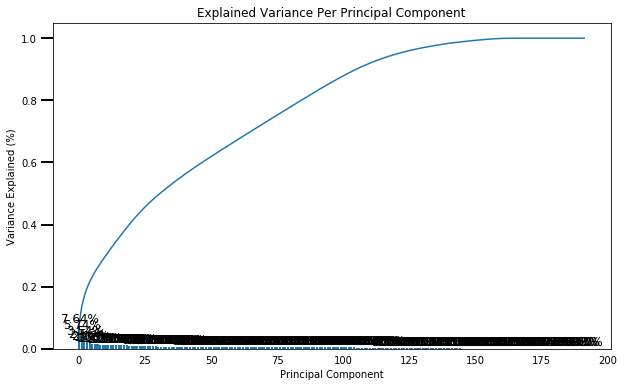

In [108]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca_Def)

In [76]:
print('The number of components in default PCA: {}'.format(len(pca_Def.components_)))
var = 0
for i in range(len(pca_Def.components_)):
    var += pca_Def.explained_variance_ratio_[i]
    if var > 0.85:
        break
print('Using {} components, we can explain {}% of the variability in the original data.'.format(i,var*100))

The number of components in default PCA: 192
Using 94 components, we can explain 85.07276977892334% of the variability in the original data.


In [77]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_94 = PCA(n_components=94)
data_pca_94 = pca_94.fit_transform(azdias_scaled)

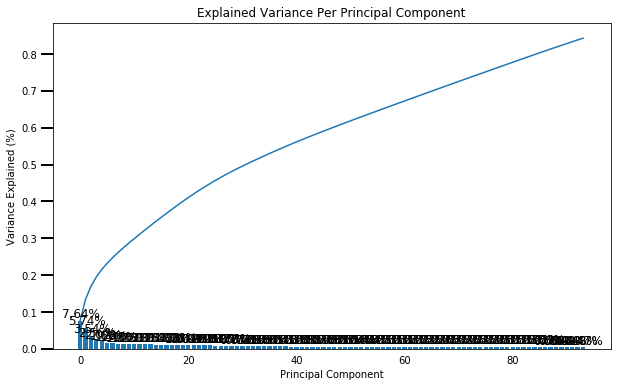

In [78]:
scree_plot(pca_94)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

1. In the default PCA, 192 components are present.
2. From the scree plot, we can observe that around 85 percent of the variance can be explained by retaining around 90 components.
3. We will keep 92 components in the second iteration, since Using we can explain 85.07276977892334% of the variability in the original data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [79]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def PCA_weights(df,pca,component):
    weights=pd.DataFrame(pca.components_,columns=list(df.columns)).iloc[component]
    weights.sort_values(ascending=False, inplace=True)
    return weights

In [80]:
# First component weights
PCA_weights(azdias_scaled,pca_94,0)

LP_STATUS_GROB_1.0      0.198337
WEALTH                  0.187747
HH_EINKOMMEN_SCORE      0.186701
PLZ8_ANTG3              0.178800
ORTSGR_KLS9             0.157188
EWDICHTE                0.156217
PLZ8_ANTG4              0.155636
FINANZ_HAUSBAUER        0.147534
PLZ8_ANTG2              0.127452
LP_STATUS_FEIN_1.0      0.125914
FINANZ_SPARER           0.125666
LP_STATUS_FEIN_2.0      0.121107
FINANZTYP_1.0           0.120644
CAMEO_DEUG_2015_9       0.115658
ARBEIT                  0.115274
ANZ_HAUSHALTE_AKTIV     0.115255
RELAT_AB                0.109422
CAMEO_DEUG_2015_8       0.093375
SEMIO_PFLICHT           0.093048
KBA05_ANTG3             0.090706
SEMIO_REL               0.088476
LP_FAMILIE_FEIN_1.0     0.087168
LP_FAMILIE_GROB_1.0     0.087168
ZABEOTYP_5.0            0.081199
DECADE                  0.077849
SEMIO_RAT               0.077652
KBA05_ANTG4             0.073187
REGIOTYP                0.070662
SEMIO_TRADV             0.068421
GEBAEUDETYP_3.0         0.068112
          

In [81]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(azdias_scaled,pca_94,1)


ALTERSKATEGORIE_GROB     0.229693
FINANZ_VORSORGER         0.215145
ZABEOTYP_3.0             0.200687
SEMIO_ERL                0.179140
SEMIO_LUST               0.162172
RETOURTYP_BK_S           0.155762
W_KEIT_KIND_HH           0.129341
CJT_GESAMTTYP_2.0        0.106391
LP_STATUS_FEIN_1.0       0.102908
FINANZTYP_5.0            0.098277
FINANZ_HAUSBAUER         0.095645
FINANZTYP_2.0            0.088285
FINANZ_MINIMALIST        0.077163
SEMIO_KRIT               0.074621
SHOPPER_TYP_3.0          0.072274
EWDICHTE                 0.072193
ORTSGR_KLS9              0.071052
CJT_GESAMTTYP_1.0        0.070100
PLZ8_ANTG3               0.069837
WEALTH                   0.069416
FINANZTYP_6.0            0.065667
LP_FAMILIE_FEIN_1.0      0.065069
LP_FAMILIE_GROB_1.0      0.065069
NATIONALITAET_KZ_1.0     0.062285
SEMIO_KAEM               0.060883
GFK_URLAUBERTYP_4.0      0.060080
PLZ8_ANTG4               0.056201
ARBEIT                   0.056134
ANZ_HAUSHALTE_AKTIV      0.052816
RELAT_AB      

In [82]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
PCA_weights(azdias_scaled,pca_94,2)

SEMIO_VERT               0.322666
SEMIO_FAM                0.263147
SEMIO_SOZ                0.257989
SEMIO_KULT               0.254348
FINANZTYP_5.0            0.132064
FINANZ_MINIMALIST        0.129906
SHOPPER_TYP_0.0          0.124477
SEMIO_REL                0.113201
ZABEOTYP_1.0             0.112819
SEMIO_MAT                0.090274
RETOURTYP_BK_S           0.076313
W_KEIT_KIND_HH           0.073814
SHOPPER_TYP_1.0          0.056503
GREEN_AVANTGARDE         0.055643
ORTSGR_KLS9              0.052945
EWDICHTE                 0.052741
ZABEOTYP_6.0             0.051384
FINANZ_VORSORGER         0.049167
LP_STATUS_FEIN_1.0       0.045680
PLZ8_ANTG3               0.043094
LP_STATUS_FEIN_3.0       0.041253
PLZ8_ANTG4               0.039544
LP_STATUS_FEIN_10.0      0.037820
LP_STATUS_GROB_5.0       0.037820
PLZ8_ANTG2               0.031850
ARBEIT                   0.031214
RELAT_AB                 0.031000
LP_STATUS_GROB_3.0       0.029728
NATIONALITAET_KZ_2.0     0.029148
GFK_URLAUBERTY

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### First component:
1. Components with positive values:
    - LP_STATUS_GROB_1.0      0.198337
    - WEALTH                  0.187747
    - HH_EINKOMMEN_SCORE      0.186701
    - PLZ8_ANTG3              0.178800
    - ORTSGR_KLS9             0.157188
    - EWDICHTE                0.156217
    - PLZ8_ANTG4              0.155636
2. Components with negative values:
    - MOBI_REGIO             -0.205886
    - FINANZ_MINIMALIST      -0.198008
    - KBA05_ANTG1            -0.193452
    - PLZ8_ANTG1             -0.182707
    - KBA05_GBZ              -0.181015
3. In general, the first component gives information about the social status, family size, personal wealth, and income.

#### Second component:
1. Components with positive values:
    - ALTERSKATEGORIE_GROB     0.229693
    - FINANZ_VORSORGER         0.215145
    - ZABEOTYP_3.0             0.200687
    - SEMIO_ERL                0.179140
    - SEMIO_LUST               0.162172
    - RETOURTYP_BK_S           0.155762
2. Components with negative values:
    - DECADE                  -0.233822
    - FINANZ_SPARER           -0.221084
    - FINANZ_UNAUFFAELLIGER   -0.212374
    - SEMIO_REL               -0.210448
3. In general, the second component gives information about the financial topology, age, personal topology(eg: religion), and decade.

#### Third component:
1. Components with positive values:
    - SEMIO_VERT               0.322666
    - SEMIO_FAM                0.263147
    - SEMIO_SOZ                0.257990
    - SEMIO_KULT               0.254348
2. Components with negative values:
    - ANREDE_KZ               -0.349417
    - SEMIO_KAEM              -0.320919
    - SEMIO_DOM               -0.290874
    - SEMIO_KRIT              -0.269217
3. In general, the third component is based on the various aspects of the personal topology.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
centers = np.arange(15,25)

for i in centers:
    model = KMeans(n_clusters=i)
    model.fit(data_pca_94)
    scores.append(np.abs(model.score(data_pca_94)))

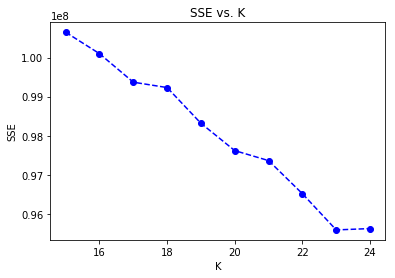

In [68]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=23)
final_model = kmeans.fit(data_pca_94)
labels = final_model.predict(data_pca_94)

In [86]:
# Save the final PCA model for further use
model_path_PCA = './FinalPCAModel.sav'
pickle.dump(pca_94, open(model_path_PCA, 'wb'))

# Save the final cluster model for further use
model_path_Cluster = './FinalClusterModel.sav'
pickle.dump(final_model, open(model_path_Cluster, 'wb'))

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- K cluster method was applied for various cluster sizes between 15 to 25.
- As observed from the graph, the elbow method cannot be clearly applied.
- After increasing the cluster size more than 23, we can see an increase in average distance.
- Hence, n = 23 is selected for the final K means clustering model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [109]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';',escapechar='\\',error_bad_lines = False)

In [110]:
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [111]:
customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [20]:
# # Load the PCA model if required.
# model_path_PCA = './FinalPCAModel.sav'
# pca_94 = pickle.load(open(model_path_PCA, 'rb'))

# # Load the cluster model if required.
# model_path_cluster = './FinalClusterModel.sav'
# final_model = pickle.load(open(model_path_cluster, 'rb'))

In [112]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean= clean_data(customers,feat_info)

The following features would be removed:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX
KKK
REGIOTYP


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


AGER_TYP Column dropped
TITEL_KZ Column dropped
KK_KUNDENTYP Column dropped
Feature LP_LEBENSPHASE_FEIN is removed
Feature LP_LEBENSPHASE_GROB is removed
Feature WOHNLAGE is removed
Feature PLZ8_BAUMAX is removed


In [113]:
customers_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1,1.0,...,0,0,0,0,0,0,2.0,1.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1,2.0,...,0,0,0,0,0,0,2.0,1.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,1.0,0.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0,3.0,...,0,0,0,0,0,0,4.0,0.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1,3.0,...,0,0,0,0,0,0,2.0,1.0,3.0,4.0


In [114]:
rows_cust,columns_cust=customers_clean.shape
print("Number of rows in the customer dataset after cleaning :{}".format(rows_cust))
print("Number of columnsin the customer dataset after after cleaning :{}".format(columns_cust))

Number of rows in the customer dataset after cleaning :141725
Number of columnsin the customer dataset after after cleaning :189


In [115]:
customers_clean.isnull().sum().sum()

84088

In [116]:
customers_clean =customers_clean.fillna(customers_clean.median().iloc[0])
customers_clean.isnull().sum().sum()

0

In [117]:
# Apply feature scaling to the customer data.
scaler =StandardScaler()
customer_scaled=scaler.fit_transform(customers_clean)
customer_scaled=pd.DataFrame(customer_scaled,columns=customers_clean.columns.tolist())

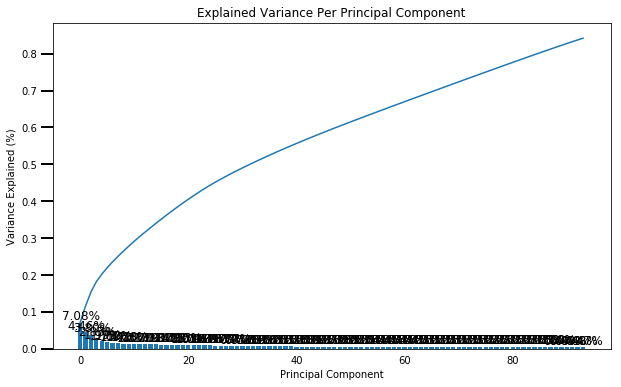

In [118]:
# PCA to customer data
customers_pca_94=pca_94.fit_transform(customer_scaled)
scree_plot(pca_94)

In [119]:
# Predict for customer data
customers_labels= final_model.predict(customers_pca_94)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

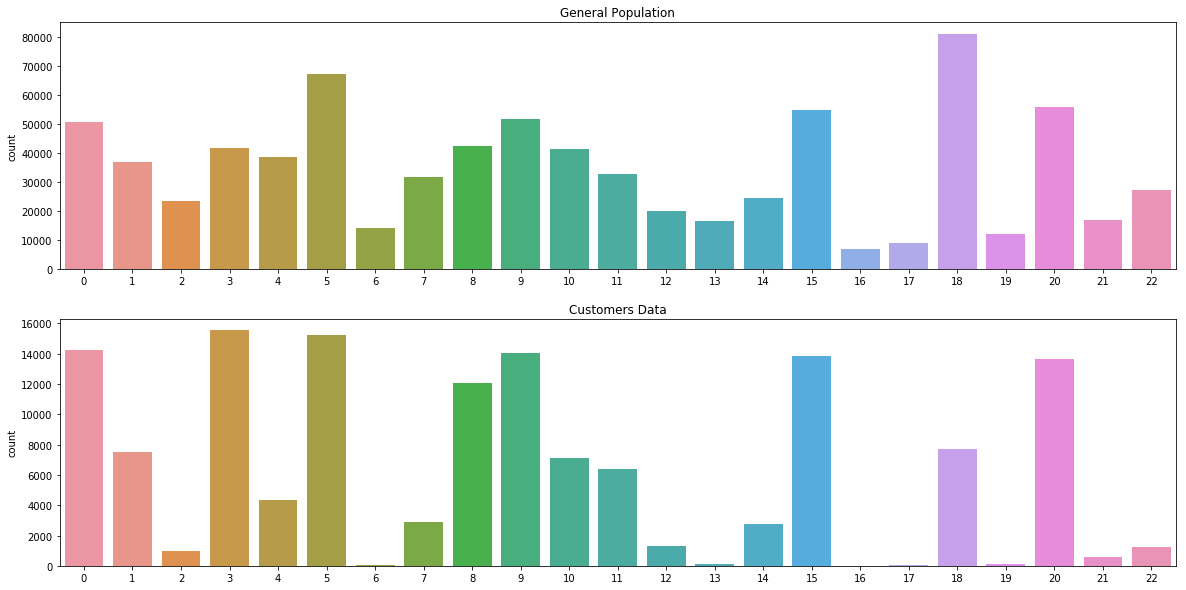

In [122]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# def compare_clusters(general,customer):
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(20)
fig.set_figheight(10)
ax1.set_title('General Population')
sns.countplot(labels,ax=ax1)

ax2.set_title('Customers Data')
sns.countplot(customers_labels,ax=ax2)
plt.show()

In [143]:
cust_prop = pd.DataFrame(customers_labels,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(customers_labels)
pop_prop = pd.DataFrame(labels,columns=['Cluster']).reset_index().groupby('Cluster').count()/len(labels)
diff = (cust_prop-pop_prop)
diff.rename({'index':'Difference'}, axis=1, inplace=True)
cust_prop.rename({'index':'Customer Proportion'}, axis=1, inplace=True)
pop_prop.rename({'index':'Population Proportion'}, axis=1, inplace=True)

proportions = cust_prop.join(pop_prop).join(diff).sort_values('Difference',ascending=False)
proportions.fillna(0, inplace=True)
proportions

,Customer Proportion,Population Proportion,Difference
Cluster,,,
3,0.109628,0.052290,0.057337
0,0.100610,0.063322,0.037288
9,0.098917,0.064620,0.034297
8,0.085003,0.053105,0.031898
15,0.097605,0.068824,0.028780
20,0.096222,0.069892,0.026330
5,0.107539,0.084207,0.023333
1,0.053025,0.046210,0.006816
11,0.045094,0.041268,0.003827


As seen in the above comparison, cluster 3 is highly overrated in the customer data.
Also, cluster 18 is underrated in the customer data.

In [144]:
# Inverse transform to extract cluster centers
cluster_description = pd.DataFrame(scaler.inverse_transform(pca_94.inverse_transform(final_model.cluster_centers_)), columns=customers_clean.columns)
cluster_description

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.041070,1.574837,4.784640,0.232854,5.731272,0.748895,0.711095,3.276390,0.436603,1.854908,...,0.008710,0.014328,0.003165,-0.007693,0.000992,0.030474,1.184067,0.400661,2.219847,3.877360
1,2.483232,1.344116,4.192242,1.570250,4.461298,1.483561,2.101016,2.624207,0.472006,2.854656,...,-0.051871,0.015984,-0.007779,0.015110,0.023739,0.006555,3.342520,0.541420,2.134456,3.390500
2,3.769514,1.529328,2.907785,1.895362,4.115869,1.877400,2.141150,3.962033,0.227891,1.621874,...,0.077097,0.013731,0.032486,0.048652,-0.014152,0.007236,3.446742,0.265052,3.362562,3.026896
3,3.986849,0.813122,5.106280,0.188256,5.821171,-0.056568,0.945567,3.045930,0.773153,1.666053,...,0.007430,0.015773,0.000707,0.009034,0.012595,0.020977,0.959671,0.730461,2.523811,3.699402
4,3.115817,1.475124,2.786714,2.525927,3.547827,2.765097,2.508425,3.585964,0.179739,2.142295,...,0.036658,-0.000907,0.008387,-0.007614,0.024364,0.035478,4.253989,0.248688,3.494826,2.386969
5,3.998526,1.895485,3.361592,1.104310,4.944318,1.503501,1.227893,4.283208,0.295038,1.756953,...,0.055652,0.025703,0.021899,0.019486,0.051585,0.043083,2.036982,0.393886,3.924944,3.550386
6,3.843253,1.063600,4.984754,1.275014,4.626113,1.711426,1.833135,1.832138,0.683084,1.530979,...,0.219339,-0.059872,-0.095547,-0.020575,0.062558,0.050017,2.824065,0.791833,1.747492,4.534173
7,2.899600,1.501544,3.608310,1.816840,4.194031,2.124435,1.916226,3.095541,0.334302,2.407044,...,0.055131,0.014765,0.010331,0.025379,0.021363,-0.001066,3.788770,0.336424,3.655125,3.498905
8,2.857466,1.287575,4.383010,1.550072,4.474129,1.944704,1.871221,2.433983,-0.065218,2.775736,...,0.025449,-0.002985,-0.002863,-0.008110,-0.020852,-0.005722,3.281104,-0.067579,1.979026,3.167805
9,3.294486,1.250840,5.073754,1.827125,4.169643,1.881146,2.459788,1.294653,1.072918,2.224054,...,-0.004846,0.024797,0.013608,0.006304,0.038191,-0.017814,3.669234,1.133167,1.434588,3.340177


In [145]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 3
cluster_description.iloc[3,:]

ALTERSKATEGORIE_GROB     3.986849
ANREDE_KZ                0.813122
FINANZ_MINIMALIST        5.106280
FINANZ_SPARER            0.188256
FINANZ_VORSORGER         5.821171
FINANZ_ANLEGER          -0.056568
FINANZ_UNAUFFAELLIGER    0.945567
FINANZ_HAUSBAUER         3.045930
GREEN_AVANTGARDE         0.773153
HEALTH_TYP               1.666053
RETOURTYP_BK_S           4.950812
SEMIO_SOZ                5.257558
SEMIO_FAM                4.885128
SEMIO_REL                3.533015
SEMIO_MAT                4.125337
SEMIO_VERT               7.000366
SEMIO_LUST               6.490640
SEMIO_ERL                3.675260
SEMIO_KULT               5.176045
SEMIO_RAT                1.773561
SEMIO_KRIT               2.247282
SEMIO_DOM                2.589373
SEMIO_KAEM               1.584415
SEMIO_PFLICHT            2.309431
SEMIO_TRADV              2.728370
SOHO_KZ                  0.008569
VERS_TYP                 1.301411
ANZ_PERSONEN             2.018725
ANZ_TITEL                0.025861
HH_EINKOMMEN_S

In [146]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Cluster 18
cluster_description.iloc[18,:]

ALTERSKATEGORIE_GROB     2.807293
ANREDE_KZ                1.502740
FINANZ_MINIMALIST        3.445750
FINANZ_SPARER            2.323678
FINANZ_VORSORGER         3.704697
FINANZ_ANLEGER           2.555635
FINANZ_UNAUFFAELLIGER    2.448485
FINANZ_HAUSBAUER         2.760635
GREEN_AVANTGARDE         0.130006
HEALTH_TYP               2.428616
RETOURTYP_BK_S           3.557242
SEMIO_SOZ                3.985713
SEMIO_FAM                4.010697
SEMIO_REL                3.742701
SEMIO_MAT                3.702100
SEMIO_VERT               4.384179
SEMIO_LUST               4.200039
SEMIO_ERL                4.834885
SEMIO_KULT               4.036850
SEMIO_RAT                3.986527
SEMIO_KRIT               4.425904
SEMIO_DOM                4.761061
SEMIO_KAEM               4.526957
SEMIO_PFLICHT            4.187628
SEMIO_TRADV              3.535555
SOHO_KZ                  0.013193
VERS_TYP                 1.680065
ANZ_PERSONEN             2.719970
ANZ_TITEL                0.010029
HH_EINKOMMEN_S

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Both the customer and population clusters are fairly similar to each other. Let us discuss on 2 clusters having the most difference and the attributes of the corresponding customer segments.

#### Cluster 3 is overrepresnted in the customer data compared to the general population.
- This means, the customers described by cluster 3 are relatively popular with the mail-order company.
- The cluster represents the following: Male customers above more than 50 years old, being financial minimalist, do not mind spending money, owns a house, is a member of GREEN_AVANTGARDE and so on.
- Personality typology:
    - Highest affinity: rational
    - High affinity: religious, event oriented, critically minded
    - Average affinity: materialistic
    - Low affinity: socially minded, family minded
    - lowest affinity: dreamful, sensually minded
- Similarly, other aspects:
    - Decade: 1940's
    - Movement: Avantgarde
    - Wealth: Prosporous/Comfortable house
    - Life stage: Family with school age children / Elders.
    
    
Decade: 1: 40s, 2: 50s, 3: 60s, 4: 70s, 5: 80s, 6: 90s
Movement = 0: mainstream, 1: Avantgarde
Wealth = 1: wealthy house, 2: prosperous house, 3: Comfortable Households, 4: Less Affluent Households, 5: Poorer Households
Life stage = 1: Pre-Family Couples & Singles, 2: Young Couples With Children, 3: Families With School Age Children, 4: Elders In Retirement, 5: Older Families & Mature Couples

#### Cluster 18 is overrepresnted in the customer data compared to the general population.
- This means, the customers described by cluster 18 are relatively unpopular with the mail-order company.
- The cluster represents the following: Male/Female customers between 30-45 years old, being average to low financial minimalist, are money saving minded, like to invest money, owns a house, not members of GREEN_AVANTGARDE and so on.
- Personality typology:
    - Average affinity: Socially minded, family minded, dreamful, event oriented, sensual minded, rational
    - Low affinity: Religious, materialistic
- Similarly, other aspects:
    - Decade: 1970's
    - Movement: mainstream
    - Wealth: Comfortable house / Less Affluent Households
    - Life stage: Young Couples With Children.
   
After knowing the desctiptions of the popular and unpopular customer base, we can see that they make sense rationally. Therefore, we can conclude that the cluster model has done a good job!

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.